<a href="https://colab.research.google.com/github/MohammadMahdi1128/Machine_learning/blob/main/Autoencoder_FashionMNIST_CIFAR100_Haidar_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/MohammadMahdi1128/Machine_learning.git
%cd /content/Machine_learning

Cloning into 'Machine_learning'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 1.04 MiB | 3.08 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/Machine_learning


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MohammadMahdi1128/Machine_learning/blob/main/Autoencoder_FashionMNIST_CIFAR100_Haidar_1.ipynb)

In [8]:
!git config --global user.email "mmahdikassem2002@gmail.com"
!git config --global user.name "MohammadMahdi1128"

In [9]:
!git commit -m "commit"

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


# Autoencoder for Fashion MNIST and CIFAR-100

## Project Overview

In this project, you will implement an Autoencoder to explore and generate hybrid images by combining feature vectors from different classes. This notebook focuses on using the **Fashion MNIST** dataset, and as a challenge, you will later apply the same methodology to the **CIFAR-100** dataset.

**Tasks:**
1. Dataset Preparation and Filtering
2. Autoencoder Implementation
3. Training the Autoencoder
4. Class Feature Centroid Calculation
5. Average Image Creation
6. Hybrid Image Generation
7. CIFAR-100 Challenge Exercise

Final Goal. Create hybrid objects. E.g. First a hybrid between a sneaker and a t-shirt and later a hybrid between a car and a plane.

**Important**: At the end you should write a report of adequate size, which will probably mean at least half a page. In the report you should describe how you approached the task. You should describe:
- Encountered difficulties (due to the method, e.g. "not enough training samples to converge", not technical like "I could not install a package over pip")
- Steps taken to alleviate difficulties
- General description of what you did, explain how you understood the task and what you did to solve it in general language, no code.
- Potential limitations of your approach, what could be issues, how could this be hard on different data or with slightly different conditions
- If you have an idea how this could be extended in an interesting way, describe it.


## Step 1: Dataset Preparation

We will work with the **Fashion MNIST** dataset, which contains 10 classes of grayscale images representing items of clothing.

### Your Tasks:
1. Load the Fashion MNIST dataset using `torchvision.datasets`.
2. Apply necessary transformations, including:
   - Normalization to scale pixel values.
   - Resizing if needed.
3. Create training and validation DataLoaders for efficient data loading.

### Hints:
- Use `torchvision.transforms` for preprocessing.
- Normalize images to have mean `0.5` and standard deviation `0.5`.

Start by writing your code to load and preprocess the dataset.

## **Please note, you can use code from https://github.com/junaidaliop/pytorch-fashionMNIST-tutorial/blob/main/pytorch_fashion_mnist_tutorial.ipynb to make it easier to load the dataset. However, whenever you copy&paste code without modifications you need to write a comment where you copied that code from.**

In [ ]:
#from the link proposed above
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Setting up device for GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

# Import the necessary transformations module from torchvision
import torchvision.transforms as transforms

# Step 1: Load the Fashion MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Similarly, load the Fashion MNIST test dataset.
validation_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Define the class labels for the Fashion MNIST dataset.
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

Running on cpu.


100%|██████████| 26.4M/26.4M [00:01<00:00, 16.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.18MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



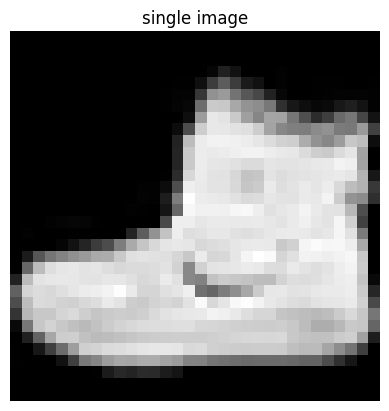

In [ ]:

# Fetch a single image for demonstration
image, _dh = train_dataset[0]

plt.imshow(image.squeeze(), cmap='gray')
plt.title("single image")
plt.axis('off')
plt.show()


## Step 2: Autoencoder Implementation

A rudimentary implementation of an Autoencoder is given here. You may need to modify it depending on your needs. That can mean adding more convolutional layers.

Note that you need to change the kernel size and stride potentially.

Depending on your input size the Adaptive Pooling may be used on a very large feature map which can reduce the performance. You will need to figure out the sizes of the input as you add more convolutional layers. One way is to remove outputs from the encoder, for example the AdaptiveAvgPool2d and then print the output shape of the encoder. After you can stop execution for example with "assert False".

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=128):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 7x7 -> 4x4
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # 4x4 -> 1x1
        )

        self.latent = nn.Linear(128, latent_dim)

        # Decoder
       # Decoder: Dynamically expands the latent representation back to the input shape
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),  # Expand back to initial channel size
            nn.Unflatten(1, (128, 1, 1)),  # Reshape to (C, H, W) for convolutional operations
            nn.ConvTranspose2d(128,128,kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Double dimensions
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Double dimensions again
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # Final upsample
            nn.Tanh()  # Ensure output values are between 0 and 1
        )


    def forward(self, x):
      # Encode

      encoded = self.encoder(x)

      encoded = encoded.view(encoded.size(0), -1)

      latent = self.latent(encoded)

      # Decode
      decoded = self.decoder(latent)

      return decoded
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
print(model)


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (latent): Linear(in_features=128, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(128, 1, 1))
    (2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding

### Your Tasks:
1. Implement the encoder and decoder parts of the Autoencoder.
2. Ensure the model takes grayscale images (1 input channel) and outputs images of the same shape.

### Hints:
- Use `nn.Conv2d` and `nn.ConvTranspose2d`.
- Add non-linear activations like `ReLU` between layers.
- Use `Tanh` or `Sigmoid` for the final activation in the decoder.

Write your Autoencoder model below.


## Step 3: Training the Autoencoder

Train your Autoencoder to reconstruct images from the Fashion MNIST dataset.

### Your Tasks:
1. Define a suitable loss function (e.g., Mean Squared Error).
2. Set up an optimizer like Adam.
3. Write a training loop to:
   - Pass inputs through the Autoencoder.
   - Compute the reconstruction loss.
   - Backpropagate and update weights.

4. Visualize the reconstructed images periodically during training.

### Hints:
- Use GPU acceleration if available (`.cuda()`).
- Visualize outputs using `matplotlib`.

Write your training loop below.


Epoch 1/24, Train Loss: 0.0840, Val Loss: 0.0479
Epoch 2/24, Train Loss: 0.0428, Val Loss: 0.0379
Epoch 3/24, Train Loss: 0.0351, Val Loss: 0.0334
Epoch 4/24, Train Loss: 0.0314, Val Loss: 0.0312


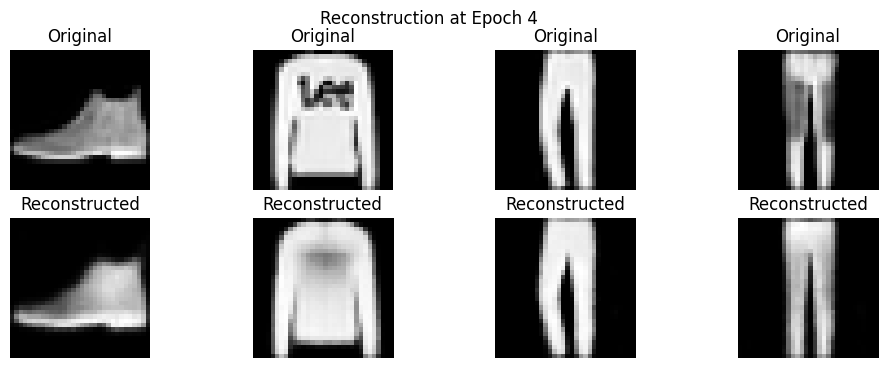

Epoch 5/24, Train Loss: 0.0292, Val Loss: 0.0288
Epoch 6/24, Train Loss: 0.0273, Val Loss: 0.0279
Epoch 7/24, Train Loss: 0.0260, Val Loss: 0.0260
Epoch 8/24, Train Loss: 0.0250, Val Loss: 0.0258


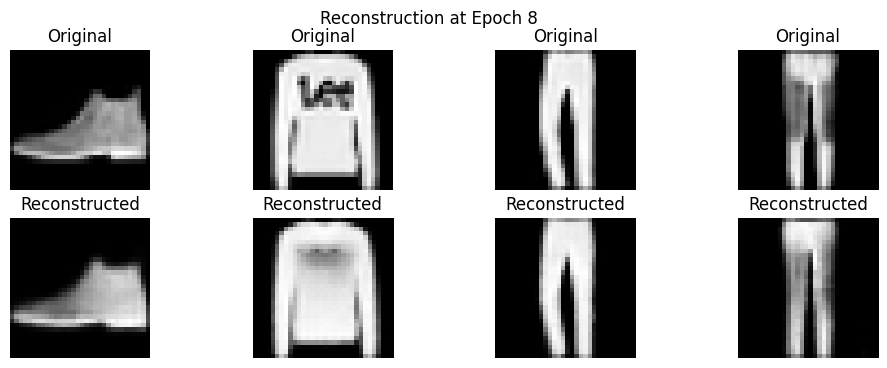

Epoch 9/24, Train Loss: 0.0244, Val Loss: 0.0249
Epoch 10/24, Train Loss: 0.0235, Val Loss: 0.0245
Epoch 11/24, Train Loss: 0.0229, Val Loss: 0.0235
Epoch 12/24, Train Loss: 0.0225, Val Loss: 0.0237


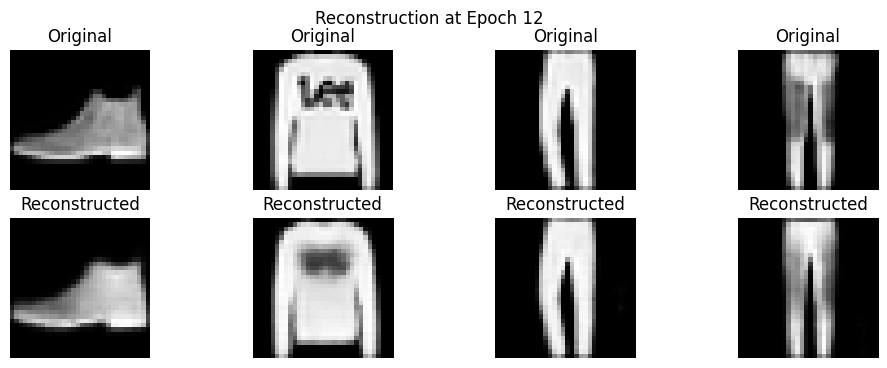

Epoch 13/24, Train Loss: 0.0220, Val Loss: 0.0231
Epoch 14/24, Train Loss: 0.0216, Val Loss: 0.0227
Epoch 15/24, Train Loss: 0.0213, Val Loss: 0.0221
Epoch 16/24, Train Loss: 0.0210, Val Loss: 0.0218


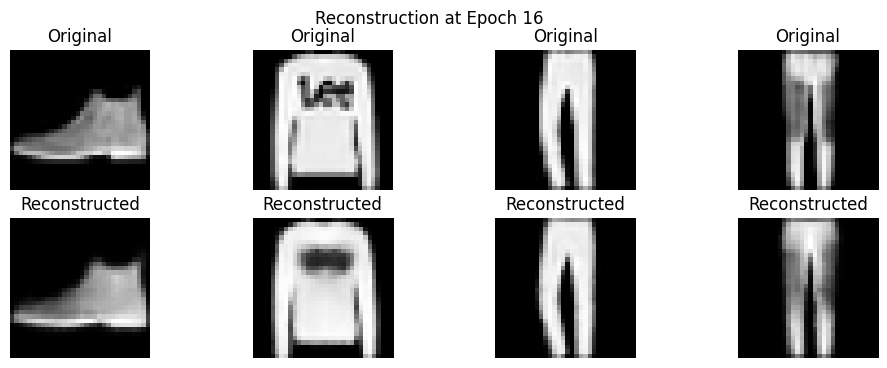

Epoch 17/24, Train Loss: 0.0206, Val Loss: 0.0217
Epoch 18/24, Train Loss: 0.0204, Val Loss: 0.0211
Epoch 19/24, Train Loss: 0.0201, Val Loss: 0.0215
Epoch 20/24, Train Loss: 0.0199, Val Loss: 0.0209


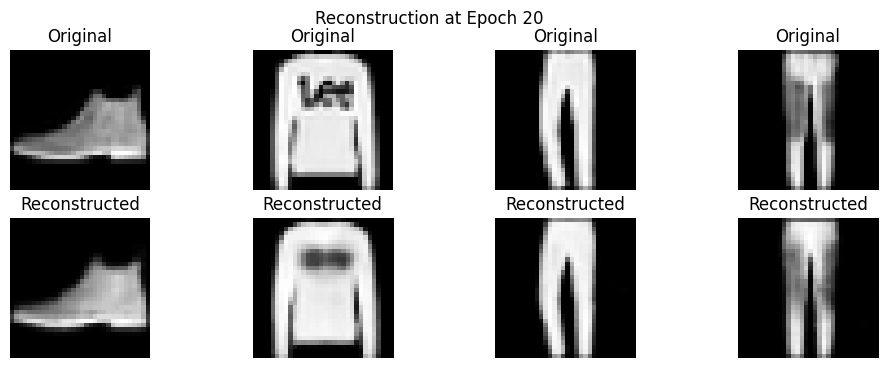

Epoch 21/24, Train Loss: 0.0218, Val Loss: 0.0211
Epoch 22/24, Train Loss: 0.0197, Val Loss: 0.0215
Epoch 23/24, Train Loss: 0.0194, Val Loss: 0.0206
Epoch 24/24, Train Loss: 0.0192, Val Loss: 0.0203


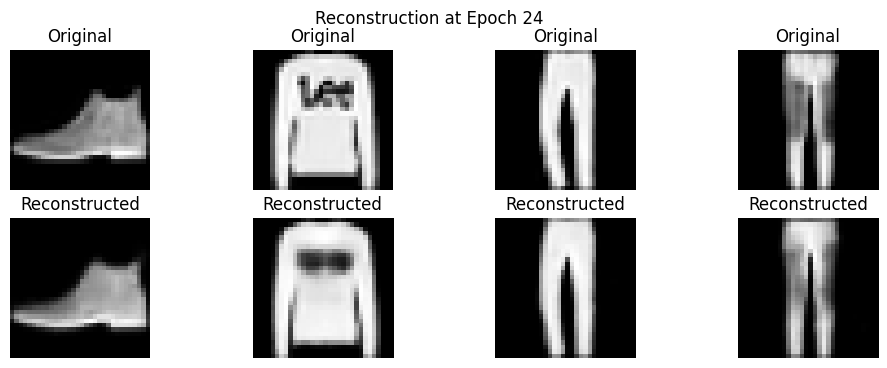

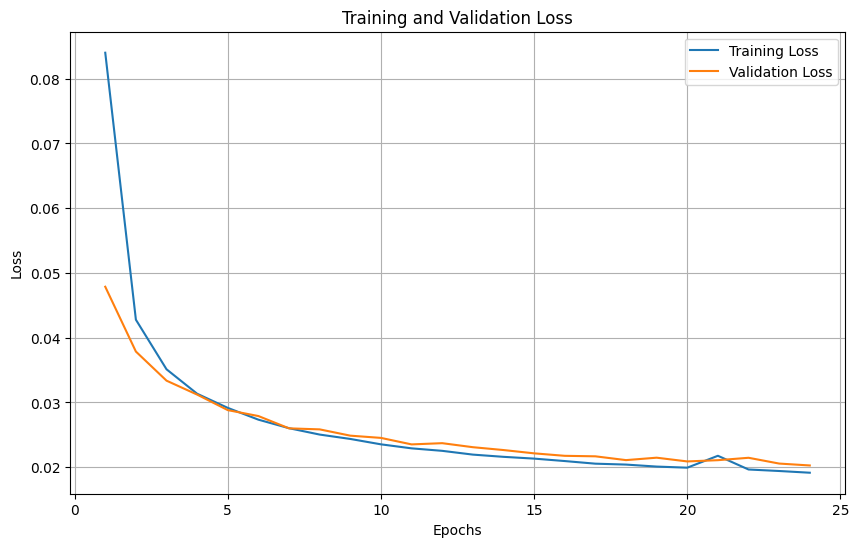

In [ ]:

import matplotlib.pyplot as plt

# Step 3: Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.004)
# Training configuration
import matplotlib.pyplot as plt

# Configuration
num_epochs = 24
train_losses = []
val_losses = []
visualize_interval = 4 # Visualize reconstructions every 5 epochs

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Calculate average training loss for this epoch
    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for val_inputs, _ in validation_loader:
            val_inputs = val_inputs.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_inputs)
            running_val_loss += val_loss.item()

    # Calculate average validation loss for this epoch
    val_loss = running_val_loss / len(validation_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Visualize reconstructed images
    if (epoch + 1) % visualize_interval == 0:
        with torch.no_grad():
            sample_inputs, _ = next(iter(validation_loader))  # Take a batch from validation data
            sample_inputs = sample_inputs.to(device)
            reconstructed = model(sample_inputs)

        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, 4, figsize=(12, 4))
        for i in range(4):  # Visualize 4 examples
            # Original images
            axes[0, i].imshow(sample_inputs[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title("Original")

            # Reconstructed images
            axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title("Reconstructed")

        plt.suptitle(f"Reconstruction at Epoch {epoch + 1}")
        plt.show()

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()



In [ ]:
torch.save(model.state_dict(), 'autoencoder_fashion_mnist.pth')
torch.save(model, 'autoencoder_fashion_mnist_model.pth')



## Step 4: Latent Space Analysis

Once the Autoencoder is trained, explore the latent space.

### Your Tasks:
1. Pass a batch of images through the encoder and store the latent representations.
2. Compute the **centroids** (average latent vectors) for each Fashion MNIST class.
3. Visualize the latent space using dimensionality reduction techniques like PCA or t-SNE.

### Hints:
- Use `sklearn.decomposition.PCA` or `sklearn.manifold.TSNE` for visualization.
- Compute centroids by averaging latent vectors of images from the same class.

Write your code to analyze the latent space below.


<ipython-input-54-342aab2e3d8c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('autoencoder_fashion_mnist.pth'))


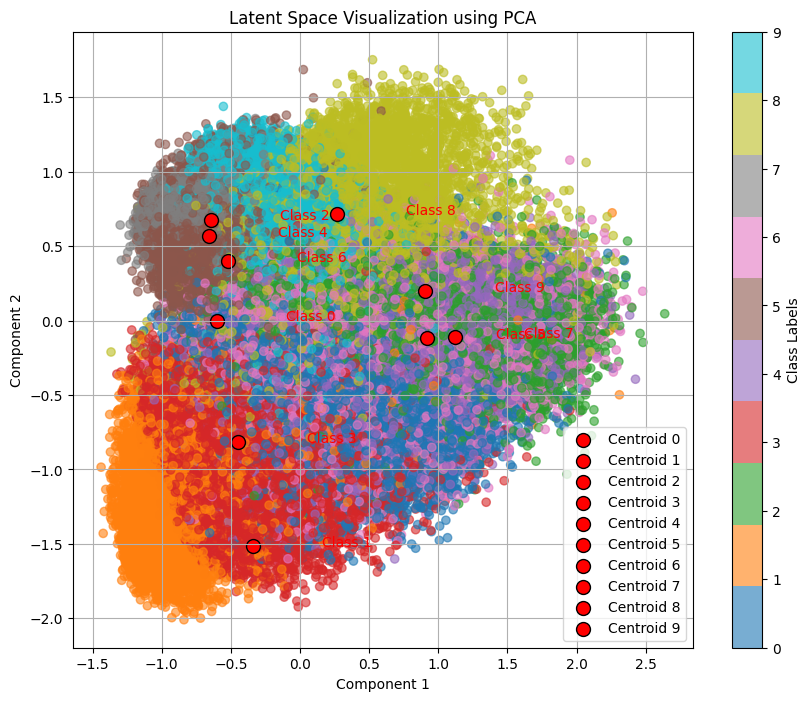

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ValueError: perplexity must be less than n_samples

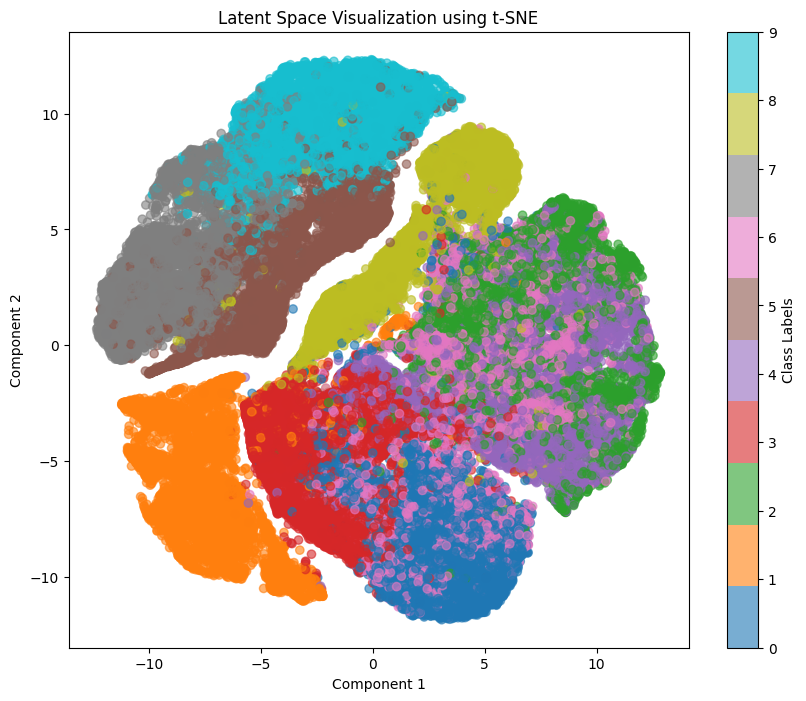

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load model
model.load_state_dict(torch.load('autoencoder_fashion_mnist.pth'))
model.eval()

# Function to compute centroids of latent representations for each class
def compute_latent_centroids(model, data_loader):
    """
    Compute latent representations and centroids for each class.

    Args:
    - model: Trained Autoencoder model.
    - data_loader: DataLoader for dataset.

    Returns:
    - latents: Array of all latent representations.
    - labels: Array of corresponding labels.
    - centroids: Dictionary of centroids for each class.
    """
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            # Extract latent space
            encoded = model.encoder(inputs)  # Pass through encoder
            encoded = encoded.view(encoded.size(0), -1)  # Flatten
            latent = model.latent(encoded)  # Apply latent layer

            latents.append(latent.cpu().numpy())
            labels.append(targets.numpy())

    latents = np.vstack(latents)
    labels = np.concatenate(labels)

    # Compute centroids
    centroids = {}
    for class_label in np.unique(labels):
        class_latents = latents[labels == class_label]
        centroids[class_label] = np.mean(class_latents, axis=0)

    return latents, labels, centroids


# Visualization Function
def visualize_latent_space(latents, labels, centroids, method="PCA"):
    """
    Visualizes the latent space using dimensionality reduction.

    Args:
    - latents: Array of latent representations.
    - labels: Array of corresponding class labels.
    - centroids: Dictionary of centroids for each class.
    - method: Dimensionality reduction method ("PCA" or "t-SNE").
    """
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "t-SNE":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    else:
        raise ValueError("Invalid method. Choose 'PCA' or 't-SNE'.")

    reduced_latents = reducer.fit_transform(latents)

    # Plot the reduced latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_latents[:, 0], reduced_latents[:, 1], c=labels, cmap='tab10', alpha=0.6
    )
    plt.colorbar(scatter, label="Class Labels")
    plt.title(f"Latent Space Visualization using {method}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # Overlay centroids
    reduced_centroids = reducer.fit_transform(np.vstack(list(centroids.values())))
    for i, (label, coord) in enumerate(zip(centroids.keys(), reduced_centroids)):
        plt.scatter(coord[0], coord[1], color="red", edgecolor="black", s=100, label=f"Centroid {label}")
        plt.text(coord[0] + 0.5, coord[1], f"Class {label}", fontsize=10, color="red")
    plt.legend(loc="best", fontsize=10)
    plt.grid()
    plt.show()


# Compute latent representations and centroids
latents, labels, centroids = compute_latent_centroids(model, train_loader)

# Visualize latent space using PCA
visualize_latent_space(latents, labels, centroids, method="PCA")

# Visualize latent space using t-SNE
visualize_latent_space(latents, labels, centroids, method="t-SNE")



## Step 5: Hybrid Image Generation

Using the latent space centroids, you can create hybrid images by interpolating between centroids of two classes.

### Your Tasks:
1. Select two class centroids (e.g., "T-shirt" and "Sneaker").
2. Linearly interpolate between the centroids with a parameter `alpha` in [0, 1].
3. Decode the interpolated latent representations back into image space.

### Hints:
- Use a simple linear interpolation formula: `(1 - alpha) * centroid1 + alpha * centroid2`.
- Visualize the hybrid images for different values of `alpha`.

Write your code to generate hybrid images below.


<built-in method keys of dict object at 0x7aab4865d100>


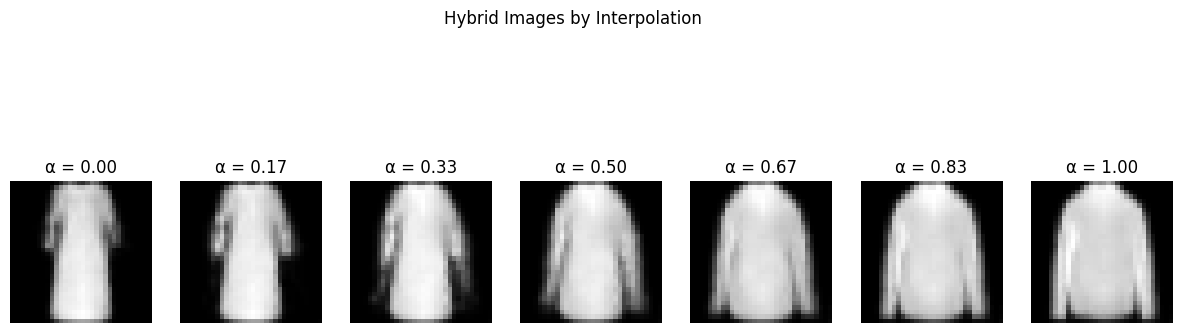

Distances between centroids:
Distance between class 0 and class 1: 1.9667
Distance between class 0 and class 2: 1.3987
Distance between class 0 and class 3: 1.3145
Distance between class 0 and class 4: 1.4063
Distance between class 0 and class 5: 1.8130
Distance between class 0 and class 6: 0.8940
Distance between class 0 and class 7: 1.9815
Distance between class 0 and class 8: 1.5960
Distance between class 0 and class 9: 2.0235
Distance between class 1 and class 2: 2.2704
Distance between class 1 and class 3: 1.3182
Distance between class 1 and class 4: 2.2143
Distance between class 1 and class 5: 2.0552
Distance between class 1 and class 6: 2.0330
Distance between class 1 and class 7: 2.2070
Distance between class 1 and class 8: 2.4531
Distance between class 1 and class 9: 2.3761
Distance between class 2 and class 3: 1.8334
Distance between class 2 and class 4: 0.7450
Distance between class 2 and class 5: 1.8962
Distance between class 2 and class 6: 0.7021
Distance between class 2 a

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
print(centroids.keys)
def interpolate_and_generate_images(model, centroids, class1, class2, alphas, device):
    """
    Interpolate between centroids of two classes and generate hybrid images.

    Args:
    - model: Trained autoencoder model.
    - centroids: Dictionary of class centroids in latent space.
    - class1: Label of the first class for interpolation.
    - class2: Label of the second class for interpolation.
    - alphas: List of interpolation values between 0 and 1.
    - device: Device to perform computations on (CPU/GPU).

    Returns:
    - hybrid_images: List of decoded images from the interpolated latent vectors.
    """
    # Extract centroids for the selected classes
    centroid1 = centroids[class1]
    centroid2 = centroids[class2]

    hybrid_images = []
    for alpha in alphas:
        # Linear interpolation in latent space
        interpolated_latent = (1 - alpha) * centroid1 + alpha * centroid2
        interpolated_latent = torch.tensor(interpolated_latent, dtype=torch.float32).to(device)

        # Decode the interpolated latent vector to image space
        with torch.no_grad():
            decoded_image = model.decoder(interpolated_latent.unsqueeze(0)).squeeze(0).cpu().numpy()
        hybrid_images.append(decoded_image)

    return hybrid_images

def visualize_hybrid_images(hybrid_images, alphas):
    """
    Visualize hybrid images generated by interpolation.

    Args:
    - hybrid_images: List of decoded images.
    - alphas: List of interpolation values used.
    """
    plt.figure(figsize=(15, 5))
    for i, (img, alpha) in enumerate(zip(hybrid_images, alphas)):
        plt.subplot(1, len(alphas), i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"α = {alpha:.2f}")
        plt.axis("off")
    plt.suptitle("Hybrid Images by Interpolation")
    plt.show()

# Define parameters for interpolation
class1, class2 = 3,4  # Example: T-shirt (0) and Sneaker (7)
alphas = np.linspace(0, 1, 7)  # Interpolation values

# Generate hybrid images
hybrid_images = interpolate_and_generate_images(
    model,
    centroids,
    class1,
    class2,
    alphas,
    device
)

# Visualize the hybrid images
visualize_hybrid_images(hybrid_images, alphas)



import numpy as np

def compute_centroid_distances(centroids):
    """
    Compute pairwise Euclidean distances between centroids.

    Args:
    - centroids: Dictionary where keys are class labels and values are latent space centroids.

    Returns:
    - distances: A dictionary with tuple keys (class1, class2) and distance as values.
    """
    class_labels = list(centroids.keys())
    distances = {}

    for i in range(len(class_labels)):
        for j in range(i + 1, len(class_labels)):  # Avoid duplicate calculations
            class1 = class_labels[i]
            class2 = class_labels[j]
            dist = np.linalg.norm(centroids[class1] - centroids[class2])
            distances[(class1, class2)] = dist

    return distances

def print_centroid_distances(distances):
    """
    Print the distances between centroids in a readable format.

    Args:
    - distances: Dictionary with distances between centroids.
    """
    print("Distances between centroids:")
    for (class1, class2), dist in distances.items():
        print(f"Distance between class {class1} and class {class2}: {dist:.4f}")

# Calculate distances between centroids
distances = compute_centroid_distances(centroids)

# Print distances
print_centroid_distances(distances)



## Step 7: Challenge Exercise: Reimplement with CIFAR-100

Now that you've successfully implemented the Autoencoder for Fashion MNIST, your next challenge is to apply the same pipeline to the **CIFAR-100 dataset**. This dataset contains 100 classes of images, each with diverse objects, making it more challenging than Fashion MNIST.

### Your Tasks:
1. Preprocess the CIFAR-100 dataset, ensuring the images are appropriately normalized and resized if needed.
2. Redefine the Autoencoder architecture to accommodate CIFAR-100's RGB images (3 channels).
3. Train the Autoencoder on CIFAR-100 and visualize the reconstructed images.
4. Compute class centroids in the latent space for selected CIFAR-100 classes (choose a manageable subset, such as 10 classes).
5. Generate hybrid images by interpolating between class centroids in the latent space.
6. Visualize the latent space clustering for the selected CIFAR-100 classes using PCA or t-SNE.

This exercise will test your understanding of the Autoencoder pipeline and challenge you to work with a more complex dataset.
